# Friendly Playoff Pool Stats

## Set-up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#font = {'family' : 'helvetica',  # need to download helvetica
#        'size'   : 12}

font = {'family' : 'serif',
        'size'   : 12}
mpl.rc('font', **font)

In [3]:
cd 2017

/Users/daviddeepwell/Documents/Hockey/Hockey Pool/Playoffs/2017


In [4]:
def make_plot(data, save=False, text=True, legend=True):
    # make labels for each column of data (row of bar graph)
    labels = data.columns
    N_labs = len(labels)
    if not hasattr(data, 'name'):
        data.name = 'Winners'
    name_str = data.name
    name = name_str.split(" - ")[-1]
    if labels.dtype == np.array([object()]).dtype:
        add_asterix = False
    else:
        add_asterix = True
    winner = False

    # colours to use in each segment
    colors = ['#95c4e8','#a3e6be','#fbee9d','#fbbf9d','#e29dfb']

    # set-up figure
    fig = plt.figure(figsize=(12,0.5*N_labs))
    ax = fig.add_subplot(111)
    #plt.rc('text', usetex=false)
    #plt.rc('font', family='serif')
    patches = []
    a_bar = [0]*5

    rounds = ['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Stanley Cup']
    for label in labels:
        r = labels.get_loc(label) - labels.get_loc(labels[0])
        widths = data[label].values
        left = 0
        for ind in range(len(widths)):
            w = widths[ind]
            if not np.isnan(w):
                a_bar[ind] = ax.barh(r, w, align='center', left=left, edgecolor='black',
                    color=colors[ind],label=rounds[ind])
                patches.append(a_bar[ind])
                # add text
                patch = patches[-1][0] 
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                if text:
                    ax.text(x, y, "%d" % (w), ha='center',va='center')
                else:
                    ax.text(x, y, "%.2f" % (w), ha='center',va='center')
                left += w
            if ind == len(widths)-1:
                x = bl[0] + patch.get_width() + 6
                total = np.sum(np.ma.masked_invalid(widths))
                if text:
                    if add_asterix:
                        if find_winner(label) == name:
                            ax.text(x, y, "%d*" % (total), ha='center',va='center')
                            winner = True
                        else:
                            ax.text(x, y, "%d" % (total), ha='center',va='center')
                    else:
                        ax.text(x, y, "%d" % (total), ha='center',va='center')

    # set axis and add labels
    y_pos = np.arange(N_labs)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    #ax.set_xlabel('Points')
    plt.title(data.name)

    # remove plot lines
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.get_xaxis().set_ticks([])

    if legend:
        # Shrink current axis by 25%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

        # remove unused elements of a_bar
        a_bar2 = list(filter(lambda a: a != 0, a_bar))
    
        # Put a legend to the right of the current axis
        if winner:
            plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5),title='* Winner')
        else:
            plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))
    
    # save figure
    if save:
        #os.chdir('Figures')
        filename = data.name
        form = 'pdf'
        plt.savefig(filename+'.'+form, bbox_inches='tight', format=form)
        os.chdir('..')
    
    # display plot inline
    plt.show();

# Work

In [5]:
def read_round(year, rnd):
    fname = str(year)+' Friendly Playoff Pool Round '+str(rnd)+'.csv'
    if os.path.isfile(fname):
        fdata = pd.read_csv(fname, sep=',')
        header = fdata.columns.values
        if rnd == 1:
            header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4','T5','G5','T6','G6','T7','G7','T8','G8','SC','R']
        elif rnd == 2:
            header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4']
        elif rnd == 3:
            header[2:] = ['T1','G1','T2','G2']
        elif rnd == 4:
            header[2:] = ['T1','G1']
        fdata.columns = header
        # Remove the string 'Games' in games columns
        max_ind = 2**(4-rnd)+1
        for ind in ['G'+str(x) for x in range(1,max_ind)]:
            if not fdata[ind].values[0] == '- Games':
                fdata[ind] = fdata[ind].map(lambda x: x.rstrip(' Games')).astype(int)
    else:
        fdata = '-'
    return fdata

In [6]:
def get_round_points(year, rnd):
    df = read_round(year, rnd)
    if not isinstance(df, str):
        N_people = df.shape[0]-1
        if rnd < 4:
            T = 10
            G = 5
        elif rnd == 4:
            T = 20
            G = 10
        teams = [0]*N_people
        games = [0]*N_people
        for ind in range(1,N_people+1):
            if rnd == 1:
                teams[ind-1] = (df.iloc[0].values[2:-2:2] == df.iloc[ind].values[2:-2:2]).sum()
                games[ind-1] = (df.iloc[0].values[3:-2:2] == df.iloc[ind].values[3:-2:2]).sum()
            else:
                teams[ind-1] = (df.iloc[0].values[2::2] == df.iloc[ind].values[2::2]).sum()
                games[ind-1] = (df.iloc[0].values[3::2] == df.iloc[ind].values[3::2]).sum()
        pts = T*np.array(teams) + G*np.array(games)
        ser = pd.Series(pts, index=df['Name:'].values[1:])
    else:
        ser = '-'
    return ser

In [7]:
r1 = get_round_points(2017, 1)
r2 = get_round_points(2017, 2)
r3 = get_round_points(2017, 3)
r4 = get_round_points(2017, 4)

In [8]:
r1names = r1.index.values
if not isinstance(r2, str):
    r2names = r2.index.values
else:
    r2names = '-'
if not isinstance(r3, str):
    r3names = r3.index.values
else:
    r3names = '-'
if not isinstance(r4, str):
    r4names = r4.index.values
else:
    r4names = '-'

In [9]:
# compare names in different lists
all_names = r1names
#l3 = [x for x in r2names if x not in all_names]

In [10]:
pts1 = [0]*all_names.size
pts2 = [0]*all_names.size
pts3 = [0]*all_names.size
pts4 = [0]*all_names.size
SC = [0]*all_names.size
ind = 0
for name in all_names:
    if name in r1names:
        pts1[ind] = r1[name]
    else:
        pts1[ind] = np.NaN
    if name in r2names:
        pts2[ind] = r2[name]
    else:
        pts2[ind] = np.NaN
    if name in r3names:
        pts3[ind] = r3[name]
    else:
        pts3[ind] = np.NaN
    if name in r4names:
        pts4[ind] = r4[name]
    else:
        pts4[ind] = np.NaN
    if name in r1names:
        #SC[ind] = np.NaN
        #else:
        #if name == 'Jeremy' or name == 'Kollin':
        #    SC[ind] = 10
        if name == 'Michael':
            SC[ind] = 25
        else:
            SC[ind] = np.NaN
    ind = ind+1

In [11]:
all_score = np.vstack((pts1,pts2,pts3,pts4,SC))
df = pd.DataFrame(all_score, index=['R1', 'R2', 'R3', 'R4', 'SC'])
df.columns = all_names

In [12]:
df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
df_sorted.name = 'Points - '+str(2017)

In [13]:
df_sorted

,Matt,Alita,Kyle,Ron,Jackson,Jeremy,Kollin,Anthony,Andre,Josh,Michael,David,Romulus,Brian
R1,45.0,35.0,55.0,55.0,60.0,55.0,70.0,55.0,65.0,70.0,50.0,60.0,80.0,75.0
R2,NaN,10.0,20.0,35.0,40.0,30.0,25.0,25.0,30.0,35.0,30.0,60.0,20.0,45.0
R3,NaN,20.0,10.0,20.0,15.0,30.0,10.0,30.0,25.0,25.0,5.0,25.0,25.0,30.0
R4,NaN,20.0,10.0,0.0,0.0,NaN,10.0,20.0,20.0,10.0,30.0,0.0,20.0,10.0
SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN


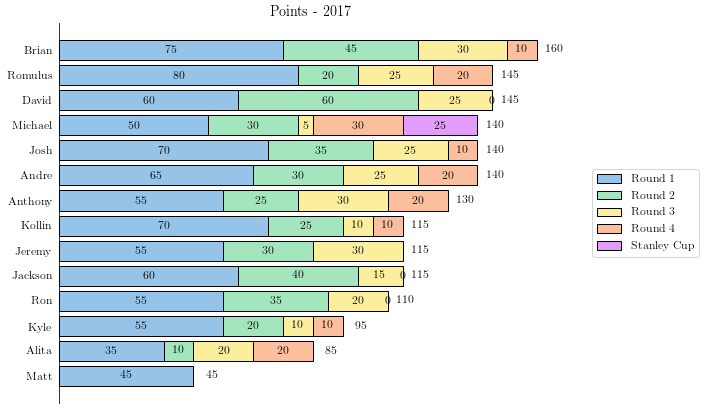

In [14]:
make_plot(df_sorted, save=True)

## Define Functions

### Data manipulation functions

In [ ]:
# Point values
def point_values( year ):
    if year <= 2007:
        T = 10
        G = 7
        # Stanley Cup points
        W = 25
        R = 15
        WR = W+R
        WF = RF = FF = N = '-'
        return [T, G, T, G, T, G, T, G, [W, R, WR, WF, RF, FF, N]]
    if  2008 <= year <= 2014:
        T = 7
        G = 10
        # Stanley Cup points
        W = 25
        R = 15
        WR = W+R
        WF = RF = FF = N= '-'
        return [T, G, T, G, T, G, T, G, [W, R, WR, WF, RF, FF, N]]
    if  year >= 2015:
        T = 10
        G = 5
        # Stanley Cup points
        W = 15
        R = 10
        WR = W+R
        WF = RF = FF = N = '-'
        return [T, G, T, G, T, G, 2*T, 2*G, [W, R, WR, WF, RF, FF, N]]

In [ ]:
# load data for a given name
def load_data( name ):
    Nnames = len(names)
    name_val = dict( zip(names, range(Nnames)))
    nn = name_val[name]
    files = os.listdir('.')
    file = files[nn]
    fdata = pd.read_csv(file, sep=' ')
    fdata.index = ['T1','G1','O1','T2','G2','O2','T3','G3','O3','T4','G4','O4','SC']
    data = pd.DataFrame(fdata)
    data.name = name
    return data

In [ ]:
def convert_to_pts( name ):
    # convert header to int
    data = data_raw[name]
    header_int = data.columns.astype(int)
    data.columns = header_int
    # convert Stanley cup strings to values
    years = header_int
    for year in years:
        pts = point_values( year )
        SC = pts[-1]
        if year == years[0]:
            d = {year : data[year].replace(to_replace=
                {'W': SC[0], 'R': SC[1], 'WR': SC[2], 'WF': SC[3], 'RF': SC[4], 'FF': SC[5], 'N': SC[6]})}
            df = pd.DataFrame(d)
        else:
            df = df.assign(year=data[year].replace(to_replace=
                {'W': SC[0], 'R': SC[1], 'WR': SC[2], 'WF': SC[3], 'RF': SC[4], 'FF': SC[5], 'N': SC[6]}))
            df = df.rename(index=str, columns = {'year': year})
    # convert strings of numbers to int
    data = df.apply(pd.to_numeric, errors='coerce')
    return data

In [ ]:
# convert nans to zero where appropriate
def convert_to_zero( name ):
    data = data_val[name]
    for year in data.columns:
        for ind in [2, 5, 8, 11]:
            if not (np.isnan(data[year][ind-2]) and np.isnan(data[year][ind-1]) and np.isnan(data[year][ind])):
                if np.isnan(data[year][ind-2]):
                    data[year][ind-2] = 0
                if np.isnan(data[year][ind-1]):
                    data[year][ind-1] = 0
                if np.isnan(data[year][ind]):
                    data[year][ind] = 0
    return data

In [ ]:
# make table of points in each round
def get_round_pts( name ):
    data = data_val[name]
    years = data.columns
    for year in years:
        pts = point_values( year )
        scr = [np.nan]*5
        for ind in [0, 3, 6, 9, 12]:
            if ind < 12:
                scr[ind//3] = np.dot(data[year].values[ind:ind+3], [pts[ind//3*2], pts[ind//3*2+1], 1])
            elif ind == 12:
                scr[ind//3] = data[year].values[ind]
        if year == years[0]:
            d = {year : pd.Series(scr, index=['R1', 'R2', 'R3', 'R4', 'SC'])}
            df = pd.DataFrame(d)
        else:
            df = df.assign(year=scr)
            df = df.rename(index=str, columns = {'year': year})
        df.name = 'Points - '+name
    return df

In [ ]:
# Make table of points for a given year
def mk_year_table( year ):
    for name in names:
        if year in data_pts[name].columns:
            d = data_pts[name][year]
            d.name = name
            if not 'df' in locals():
                df = pd.DataFrame(d)
            else:
                df = df.assign(name=d)
                df = df.rename(index=str, columns = {'name': name})
    df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
    df_sorted.name = 'Points - '+str(year)
    return df_sorted

In [ ]:
def find_winner( year ):
    df = mk_year_table(year)
    return df.columns[-1]

In [ ]:
def mk_SC_table():
    for name in names:
        data = data_raw[name]
        SC = data.loc['SC']
        WR = SC.str.count(r"WR$").sum();
        W  = SC.str.count(r"W$").sum();
        R  = SC.str.count(r"R$").sum();
        WF = SC.str.count(r"WF$").sum();
        RF = SC.str.count(r"RF$").sum();
        FF = SC.str.count(r"FF$").sum();
        N  = SC.str.count(r"N$").sum();
        atts = len(data.columns) - N
        scr = [WR, W, R, WF, RF, FF, atts]
        if not 'df' in locals():
            d = {name : pd.Series(scr, index=['WR', 'W', 'R', 'WF', 'RF', 'FF', 'attempts'])}
            df = pd.DataFrame(d)
        else:
            df = df.assign(name=scr)
            df = df.rename(index=str, columns = {'name': name})
    return df

In [ ]:
def count_SC( cat, sort='Percentage' ):
    SC = mk_SC_table()
    col = SC.sort_values(cat, axis=1, ascending=False).loc[cat]
    df = pd.DataFrame(col)
    atts = SC.loc['attempts']
    df = df.assign(Attempts=atts)
    perc = df[cat]/df['Attempts']
    df = df.assign(Percentage=perc)
    if sort == 'Percentage':
        df.sort_values(['Percentage', 'Attempts'], ascending=[False, True], inplace=True)
    elif sort == 'Total':
        df.sort_values([cat, 'Attempts'], ascending=[False, True], inplace=True)
    return df

In [ ]:
def winner_table( year ):
    for year in range(2006, year+1):
        yr = mk_year_table(year)
        winner = yr.columns[-1]
        ser = yr[winner]
        ser.name = ser.name+' - '+str(year)
        #ser = ser.append(pd.Series([2006], index=['year']))
        if not 'df' in locals():
            df = pd.DataFrame(ser)
        else:
            df = df.assign(name=ser)
            df = df.rename(index=str, columns = {'name': ser.name})
    return df

### Plotting functions

In [ ]:
def plot_year( year, save=False ):
    df = mk_year_table( year )
    make_plot(df, save=save)

In [ ]:
def plot_SC( cat, amount='Percentage' ):
    # amount = {'Percentage', 'Total'}
    if amount == 'Percentage':
        df = pd.DataFrame(count_SC(cat)['Percentage'])
    elif amount == 'Total':
        df = pd.DataFrame(count_SC(cat,sort='Total')[cat])
    df2 = df.T
    df2 = df2[df2.columns[::-1]]
    df2 = df2.drop('Sheldon',axis=1) # drop all nans (should improve)
    df2.name = 'SC '+cat+' - '+amount
    #if amount == 'Percentage':
    make_plot(df2, text=False, legend=False)
    #elif amount == 'Total':
    #    make_plot(df2, legend=False) # need to fix spacing

In [ ]:
def winner_plot( year ):
    df = winner_table(year)
    make_plot(df)

## Load and plot data

In [ ]:
# Find files and set-up variables
names = [file.split('.')[0] for file in os.listdir('.')]
# load data
data_raw = {name: load_data(name) for name in names}

In [ ]:
cd ..

In [ ]:
# Convert raw data to numerical values (data_val) and points (data_pts)
data_val = {name: convert_to_pts(name)  for name in names}
data_val = {name: convert_to_zero(name) for name in names}
data_pts = {name: get_round_pts(name)   for name in names}

In [ ]:
make_plot(data_pts['David'], save=True);

In [ ]:
plot_year(2016, save=True)

## Work

In [ ]:
count_SC('W',sort='Total')

In [ ]:
plot_SC('W',amount='Total')

In [ ]:
winner_plot(2016)